### Continuous Q-Learning with Discretization (Using Discrete Bins of Continuous Observation Space Range Values)

In [1]:
import os
import time
from typing import Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Exploring environment with basic env setup and a series of random actions ###

env = gym.make('CartPole-v1', render_mode='human')

observation, info = env.reset()

# Print info, obs space, action space
print(f'{info=}')
print(f'{observation=}')
print(f'{env.observation_space=}') # Obs space is nd.array([cart pos., cart vel., pole angle, pole angular vel.])
print(f'{env.action_space=}') # Action space is: 0, 1 = left, right
print('-'*100)

for step in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action)
    observation_rounded = np.round(observation, 2)
    print(f'{step=} | {action=} | {observation_rounded=} | {reward=} | {done=}')
    time.sleep(0.01)

    if done or truncated:
        break

env.close()

info={}
observation=array([ 0.03981761, -0.01657994,  0.0353497 , -0.01928021], dtype=float32)
env.observation_space=Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
env.action_space=Discrete(2)
----------------------------------------------------------------------------------------------------
step=0 | action=1 | observation_rounded=array([ 0.04,  0.18,  0.03, -0.3 ], dtype=float32) | reward=1.0 | done=False
step=1 | action=0 | observation_rounded=array([ 0.04, -0.02,  0.03,  0.  ], dtype=float32) | reward=1.0 | done=False
step=2 | action=0 | observation_rounded=array([ 0.04, -0.21,  0.03,  0.3 ], dtype=float32) | reward=1.0 | done=False
step=3 | action=1 | observation_rounded=array([ 0.04, -0.02,  0.04,  0.02], dtype=float32) | reward=1.0 | done=False
step=4 | action=1 | observation_rounded=array([ 0.04,  0.18,  0.04, -0.26], dtype=float32) | reward=1.0 | done=False
step=5 | action=0 | observation_rounded=array([ 0.0

#### Q-Learning Process Below

In [3]:
### Create discretization/binning functions ###

def create_bins(num_bins: Tuple[int]) -> np.ndarray:
    """
    Creates discretization bins for different features.

    Args:
        num_bins (Tuple[int]): A tuple specifying the number of bins for each feature

    Returns:
        np.ndarray: 2D array of arrays where each corresponds to a set of bins for each feature
            - Row 0: Cart position. Row 1: Cart velocity. Row 2: Pole angle. Row 3: Pole angular velocity
    """

    bins_cart_pos = np.linspace(-4.8, 4.8, num_bins[0] + 1)
    bins_cart_vel = np.linspace(-5, 5, num_bins[1] + 1) # Play game / explore env a bit to determine this range
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins[2] + 1) # In radians
    bins_pole_angular_vel = np.linspace(-5, 5, num_bins[3] + 1)

    return np.array([bins_cart_pos, bins_cart_vel, bins_pole_angle, bins_pole_angular_vel])


def discretize_observation(observations: np.ndarray, bins: np.ndarray) -> Tuple[int, ...]:
    """
    Discretizes the given observations by finding which bin each value belongs to.

    Args:
        observations (np.ndarray): 1D array containing the observation values for the four features.
        bins (np.ndarray): 2D array of arrays containing the bins for each feature.

    Returns:
        Tuple[int, ...]: Tuple of ints representing bin indices that correspond to the given observations.
    """

    return tuple(min(np.digitize(obs, bins[i]) - 1, len(bins[i]) - 2) for i, obs in enumerate(observations))


# Testing of the binning and discretization/digitize functions on a sample observation
tmp_test_bins = create_bins((10, 10, 10, 10))
print(f'{tmp_test_bins=}')
tmp_test_observations = np.array([-4.1010924,  0.799106,  0.417,  1.458236])
tmp_test_binned_observations = discretize_observation(tmp_test_observations, tmp_test_bins)
print(f'{tmp_test_binned_observations=}')

tmp_test_bins=array([[-4.8   , -3.84  , -2.88  , -1.92  , -0.96  ,  0.    ,  0.96  ,
         1.92  ,  2.88  ,  3.84  ,  4.8   ],
       [-5.    , -4.    , -3.    , -2.    , -1.    ,  0.    ,  1.    ,
         2.    ,  3.    ,  4.    ,  5.    ],
       [-0.418 , -0.3344, -0.2508, -0.1672, -0.0836,  0.    ,  0.0836,
         0.1672,  0.2508,  0.3344,  0.418 ],
       [-5.    , -4.    , -3.    , -2.    , -1.    ,  0.    ,  1.    ,
         2.    ,  3.    ,  4.    ,  5.    ]])
tmp_test_binned_observations=(0, 5, 9, 6)


In [14]:
### Define hyperparameters and Q-table ###

NUM_BINS = (30, 30, 30, 30) # cart pos., cart vel., pole angle, pole angular vel.

TOTAL_EPISODES = 50000
ALPHA = 0.5
GAMMA = 0.95

MAX_EPSILON = 1.0
MIN_EPSILON = 0.0

# For linear epsilon decay
BURN_IN = 1
EPSILON_END = 20000 # Or just use TOTAL_EPISODES in place of EPSILON_END?
EPSILON_REDUCE = 0.00005

# For exponential epsilon decay
DECAY_RATE = 0.0001

empty_q_table = np.zeros((*NUM_BINS, env.action_space.n))
print(f'{empty_q_table.shape=}')

empty_q_table.shape=(30, 30, 30, 30, 2)


In [15]:
### Define other core functions that will be used during the actual training loop ###

def select_action_epsilon_greedy(epsilon, q_table, discrete_state, env):
    """Choose either best action or random action based on random number [0,1) vs. current epsilon."""

    if np.random.random() < epsilon:
        return env.action_space.sample()
    else: # Get index of max Q-value for the current state's row from the Q-table
        return np.argmax(q_table[discrete_state])
    

def compute_next_q_value(curr_q_value, new_state_optimal_q_value, reward):
    """Update the Q-value using the Bellman equation."""

    return curr_q_value + ALPHA * (reward + GAMMA * new_state_optimal_q_value - curr_q_value)


def linear_decay_epsilon(epsilon, episode):
    """Decay epsilon (linear) after each episode to balance exploration and exploitation."""
    
    if BURN_IN <= episode <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
        
    return max(MIN_EPSILON, epsilon)


def exp_decay_epsilon(episode):
    """Decay epsilon (exponential) after each episode to balance exploration and exploitation."""

    return MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * episode)


# Note: Functions like this one, but typically more sophisticated, will be useful in defining future, more complex simulations.
def fail_episode_reward(done, curr_episode_total_reward, reward):
    """Function to inject an additional negative reward on agent failure."""

    if done and curr_episode_total_reward < 150:
        return -200
    else:
        return reward

In [16]:
### Execute the training loop ###

BINS = create_bins(NUM_BINS)

env = gym.make('CartPole-v1')
epsilon = MAX_EPSILON
q_table = np.zeros((*NUM_BINS, env.action_space.n))
episode_rewards = []
track_progress_interval = 1000 # Print performance metric(s) every _ episodes

for episode in range(TOTAL_EPISODES):

    # Reset the environment and the done variables
    state, info = env.reset()
    state_discretized = discretize_observation(state, BINS)
    done = False
    curr_episode_total_reward = 0

    # Decay epsilon
    epsilon = exp_decay_epsilon(episode)

    # Play the game until game over
    while not done:
        # Perform action and get the associated reward and new state
        action = select_action_epsilon_greedy(epsilon, q_table, state_discretized, env)
        new_state, reward, done, truncated, info = env.step(action)

        # Adding an extra custom reward function
        reward = fail_episode_reward(done, curr_episode_total_reward, reward)

        # Get Q-value of the current (or technically previous) state for the selected action
        curr_q_value = q_table[state_discretized + (action,)]

        # Get max Q-value for the new state from the Q-table
        new_state_discretized = discretize_observation(new_state, BINS)
        new_state_optimal_q_value = np.max(q_table[new_state_discretized])

        # Update the Q-table for the current (previous) state+action
        q_table[state_discretized + (action,)] = compute_next_q_value(curr_q_value, new_state_optimal_q_value, reward)

        # Track sum of rewards across the entire episode, and set the new state for next loop
        curr_episode_total_reward += reward
        state_discretized = new_state_discretized

    # Tracking performance across training
    episode_rewards.append(curr_episode_total_reward)
    if episode % track_progress_interval == 0 and episode != 0:
        avg_score_prev_100_episodes = int(np.mean(episode_rewards[episode - 100:]))
        print(f'{episode=} | {avg_score_prev_100_episodes=}')

env.close()

episode=1000 | avg_score_prev_100_episodes=-175
episode=2000 | avg_score_prev_100_episodes=-171
episode=3000 | avg_score_prev_100_episodes=-165
episode=4000 | avg_score_prev_100_episodes=-160
episode=5000 | avg_score_prev_100_episodes=-145
episode=6000 | avg_score_prev_100_episodes=-127
episode=7000 | avg_score_prev_100_episodes=-102
episode=8000 | avg_score_prev_100_episodes=-76
episode=9000 | avg_score_prev_100_episodes=-55
episode=10000 | avg_score_prev_100_episodes=-29
episode=11000 | avg_score_prev_100_episodes=-19
episode=12000 | avg_score_prev_100_episodes=72
episode=13000 | avg_score_prev_100_episodes=70
episode=14000 | avg_score_prev_100_episodes=86
episode=15000 | avg_score_prev_100_episodes=119
episode=16000 | avg_score_prev_100_episodes=134
episode=17000 | avg_score_prev_100_episodes=187
episode=18000 | avg_score_prev_100_episodes=150
episode=19000 | avg_score_prev_100_episodes=218
episode=20000 | avg_score_prev_100_episodes=223
episode=21000 | avg_score_prev_100_episodes=2

Note: Negative rewards are due to custom reward function. For negative points, steps = reward + 200.


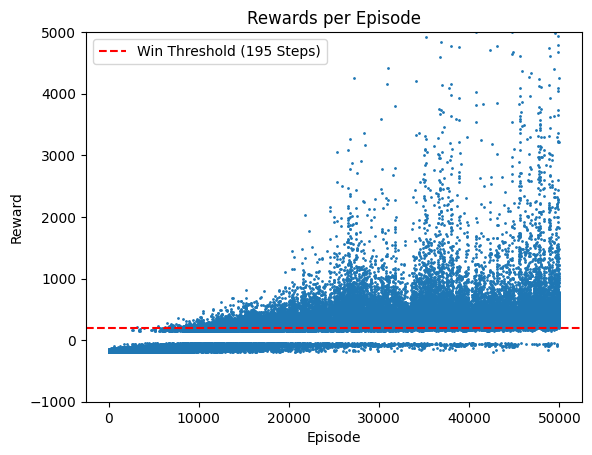

In [17]:
### Plot the episode rewards ###

# Scatter plot of reward for each episode
print('Note: Negative rewards are due to custom reward function. For negative points, steps = reward + 200.')
plt.scatter(range(len(episode_rewards)), episode_rewards, s=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(-1000, 5000) # Note: Some episodes likely hidden by upper y-limit
plt.axhline(y=195, color='r', linestyle='--', label='Win Threshold (195 Steps)')
plt.title('Rewards per Episode')
plt.legend()
plt.show()

In [18]:
### Save the model ###

# Create directory if it DNE yet
save_dir = os.path.join('models')
os.makedirs(save_dir, exist_ok=True)

# Save the Q-table
model_file_name = '4_continuous_qlearning_cartpole.npy'
full_model_path = os.path.join(save_dir, model_file_name)
np.save(full_model_path, q_table)
print(f'Q-table saved to {full_model_path}')

Q-table saved to models\4_continuous_qlearning_cartpole.npy


In [19]:
### Testing + utilization of the trained policy (i.e., the learned Q-table) ###

# Load the Q-table/model
full_model_path = os.path.join('models', '4_continuous_qlearning_cartpole.npy')
q_table = np.load(full_model_path)
print('Q-table loaded successfully from {full_model_path}')

# Define trials - CartPole problem is considered completed once agent wins (stay upright for 195+ steps) for 100 consecutive trials.
NUM_TEST_TRIALS = 100
num_wins = 0
num_fails = 0
total_steps = 0

for trial in range(NUM_TEST_TRIALS):

    # Reset environment for new trial
    state, info = env.reset()
    done = False
    step = 0

    # Play the game using the policy
    while not done:
        state_discretized = discretize_observation(state, BINS)
        action = np.argmax(q_table[state_discretized]) 
        state, reward, done, truncated, info = env.step(action)
        step += 1

    # Update results tracking for the completed episode
    total_steps += step
    if step >= 195:
        num_wins += 1
    else:
        num_fails += 1

# Print the test results
average_steps = total_steps / NUM_TEST_TRIALS
print(f'In {NUM_TEST_TRIALS} trials ran, {num_wins=} and {num_fails=} with {average_steps=}')

env.close()

Q-table loaded successfully from {full_model_path}
In 100 trials ran, num_wins=100 and num_fails=0 with average_steps=465.15
